In [2]:
!pip3 install seaborn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,LabelEncoder
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D

In [4]:
df = pd.read_excel("Mall_Customers.xlsx")
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [7]:
df.drop("CustomerID", inplace=True, axis = 1)

In [8]:
df.columns

Index(['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)'], dtype='object')

In [9]:
df.dtypes

Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

In [10]:
df.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


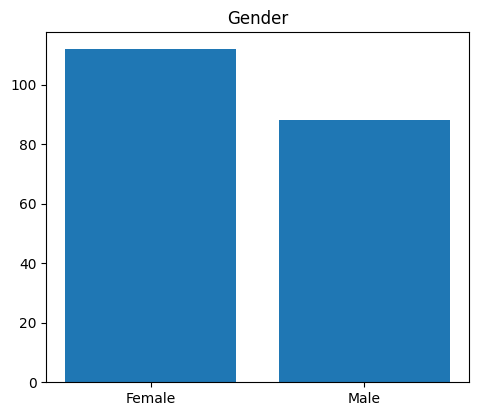

In [11]:
plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
plt.bar(df['Gender'].value_counts().keys(),df['Gender'].value_counts().values)
plt.title("Gender")    
    
plt.show()

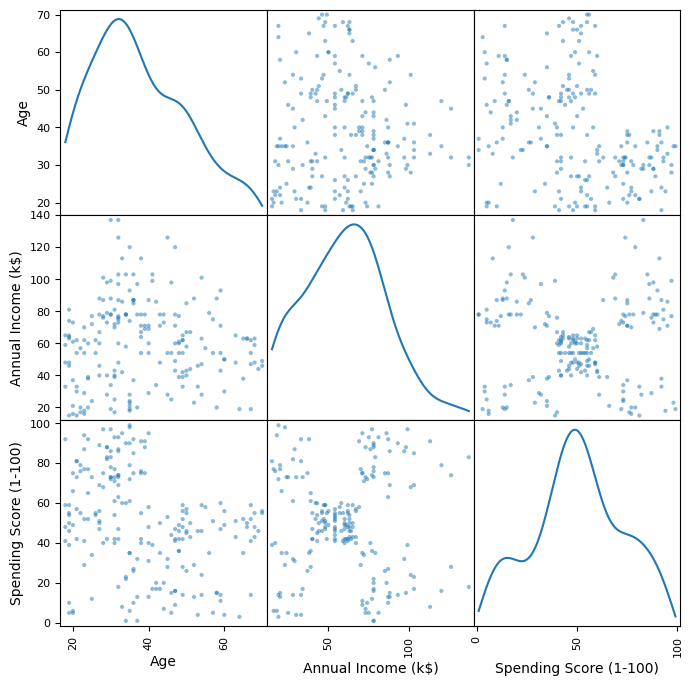

In [12]:
pd.plotting.scatter_matrix(df, figsize=(8,8), diagonal='kde')
plt.show()

In [13]:
le=LabelEncoder()
df['Gender']=le.fit_transform(df['Gender'])

In [ ]:
std_scaler=StandardScaler()

df=std_scaler.fit_transform(df)

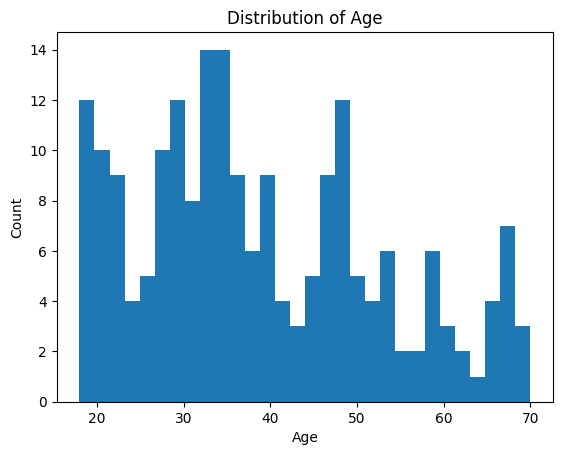

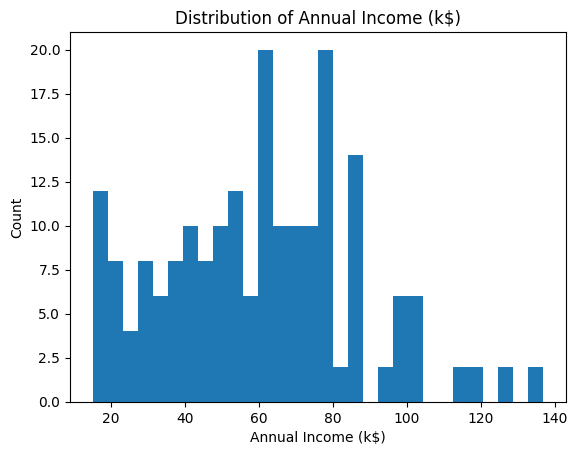

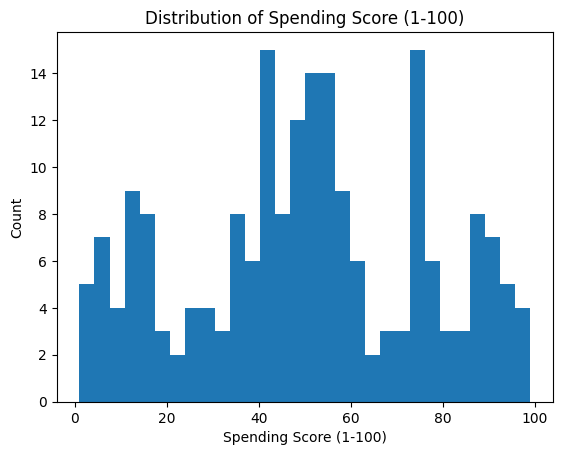

In [14]:
features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
for feature in features:
    plt.hist(df[feature], bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

In [40]:
class KMeansClustering:
    def __init__(self,k:int,distance:str,init:str,X:np.array):
        self.k=k
        self.X=X
        
        distanceMetrics={'manhantan':KMeansClustering.manhantanDistance,'eculidean':KMeansClustering.eculideanDistance}
        inits={'random':self.randomCentroidIntialisation,'KMeans++':self.KplusplusIntialisation}
        
        if distance not in distanceMetrics:
            raise ValueError(f'invalid value of distance metric , the supported ones are: {[val for val in distanceMetrics]}')
        
        if init not in inits:
            raise ValueError(f'invalid initialisation method, the supported ones are: {[val for val in inits]}')
        
        self.init=inits[init]
        self.distance=distanceMetrics[distance]
    
    @staticmethod
    def eculideanDistance(x:np.array,y:np.array):
        '''
        x and y are 2-D array of shape (n1,dim) and (n2,dim) respectively
        '''
        x=np.expand_dims(x,axis=0)
        y=np.expand_dims(y,axis=1)
        return np.sum((x-y)**2,axis=2)
    
    @staticmethod
    def manhantanDistance(x:np.array,y:np.array):
        '''
        x and y are 2-D array of shape (n1,dim) and (n2,dim) respectively
        '''
        x=np.expand_dims(x,axis=0)
        y=np.expand_dims(y,axis=1)
        return np.sum(np.abs(x,y),axis=2)
    
    def getInertia(self):
        
        labels=self.assignCluster(self.X)
        
        inertia=0
        for i in range(self.k):
            mask=labels==i
            dist=np.sum((self.X[mask]-self.centroids[i])**2)
            inertia+=dist
        
        return inertia
        # centers=self.centroids[labels]
    
    def randomCentroidIntialisation(self,random_state:int):
        np.random.seed(random_state)
        
        centroidIdx = np.random.choice(range(self.X.shape[0]), size=self.k, replace=False)
        self.centroids=self.X.iloc[centroidIdx]
        
        print("centroids intialised randomly !!")
        print(self.centroids.shape)
        
    def KplusplusIntialisation(self,random_state:int):
        np.random.seed(random_state)
        
        centroidIdx=[]
        idx1=np.random.choice(range(self.X.shape[0]),size=1,replace=False)
        centroidIdx.append(idx1.item())
        
        self.centroids=self.X.iloc[centroidIdx]
        
        for _ in range(1,self.k):
            dist=self.assignCluster(self.X,True)
            dist = dist.astype(float)
            dist/=np.sum(dist)
            idx=np.random.choice(range(self.X.shape[0]),size=1,replace=False,p=dist)
            centroidIdx.append(idx.item())
            self.centroids=self.X.iloc[centroidIdx]
        
        print("centroids intialised using K-Means++")
        print(self.centroids.shape)
        print(centroidIdx)

    def assignCluster(self,x:np.array,dist=False):
        
        distances=self.distance(x,self.centroids)
        
        if dist:
            return np.min(distances,axis=0)
        else:
            return np.argmin(distances,axis=0)
    
    def updateCentroid(self,clusterAssigned:np.array):
        
        updated=False
        for i in range(self.k):
            mask=clusterAssigned==i
            newCentroid=np.mean(self.X[mask],axis=0)
            
            if (newCentroid!=self.centroids[i]).all():
                updated=True
                self.centroids[i]=newCentroid
        
        return updated    
    
    def optimiseCentroids(self,random_seed:int):
        
        self.init(random_seed)
        
        iter=0
        while True:
            assignedClusters=self.assignCluster(self.X)
            if not self.updateCentroid(assignedClusters):
                print("number of iterations: ",iter)
                break
            iter+=1
 

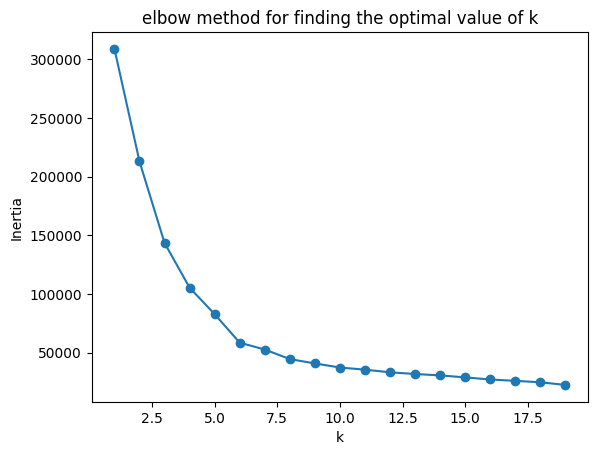

In [41]:
inertias = []
K = range(1, 20)
for k in K:
    km = KMeans(n_clusters=k, random_state=0).fit(df)
    inertias.append(km.inertia_)

plt.plot(K, inertias, marker='o')
plt.title("elbow method for finding the optimal value of k")
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

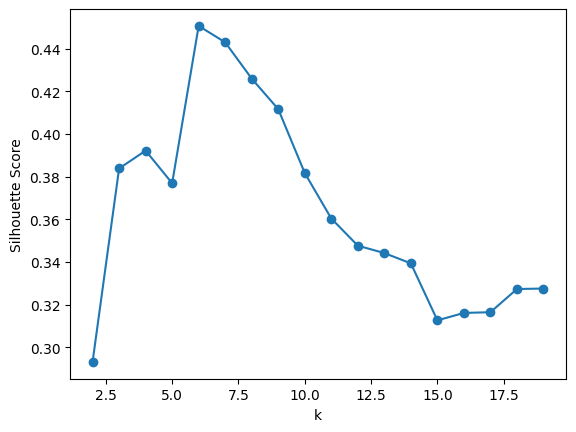

In [25]:
scores = []
for k in range(2, 20):
    km = KMeans(n_clusters=k, random_state=0).fit(df)
    score = silhouette_score(df, km.labels_)
    scores.append(score)

plt.plot(range(2, 20), scores, marker='o')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.show()